In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import torch
import torch.nn as nn

from collections import defaultdict
from itertools import combinations_with_replacement
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time

/home/ba13/anaconda3/envs/conda-torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ba13/anaconda3/envs/conda-torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
lr = 0.001
acquisition_batch_size = 100
train_batch_size = 64
num_train = 100
num_pool = 6000

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply convolutional and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        
        # Apply fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [5]:
def test(model, device, test_loader, epoch=-1):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = float(correct) / len(test_loader.dataset)

    print('Test set for epoch: {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(epoch, 
        test_loss, correct, len(test_loader.dataset),
        100. * accuracy))

    return accuracy

In [6]:
def hasnan(x):
    return torch.isnan(x).any()

def remove_occurrences_from_list(l, items):
    # print(items)
    return list(np.setdiff1d(np.array(l, dtype=int),
        np.array(items, dtype=int), assume_unique=True))

def move_data(indices, from_subset, to_subset):
    from_subset.indices = remove_occurrences_from_list(from_subset.indices, indices)
    if isinstance(to_subset.indices, list):
        to_subset.indices.extend(indices)
    elif isinstance(to_subset.indices, np.ndarray):
        to_subset.indices = np.concatenate([to_subset.indices, np.array(indices)])

In [7]:
def active(model, acquirer, device, data, optimizer):
    train_data, pool_data, test_data = data

    test_accuracies = []
    while len(pool_data) > 0:
        print(f'Acquiring {acquirer.__class__.__name__} batch. Pool size: {len(pool_data)}')
        # get the indices of the best batch of data
        batch_indices = acquirer.select_batch(model, pool_data)
        # move that data from the pool to the training set
        move_data(batch_indices, pool_data, train_data)
        # train on it
        train_loader = torch.utils.data.DataLoader(train_data,
            batch_size=train_batch_size, pin_memory=True, shuffle=True)
        train(model, device, train_loader, optimizer, 0)

        # test the accuracy
        test_loader = torch.utils.data.DataLoader(test_data,
            batch_size=train_batch_size, pin_memory=True, shuffle=True)
        test_accuracies.append(test(model, device, test_loader))

    return test_accuracies

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [9]:
dataset = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [10]:
num_classes = len(dataset.classes)
samples_per_class = (num_train) // num_classes

class_indices = defaultdict(list)

for idx, (_, target) in enumerate(dataset):
    class_indices[target].append(idx)

for indices in class_indices.values():
    np.random.shuffle(indices)

train_indices = []

for _ in range(samples_per_class):
    for indices in class_indices.values():
        train_indices.append(indices.pop())

np.random.shuffle(train_indices)

In [11]:
all_indices = np.arange(len(dataset))
remaining_indices = np.setdiff1d(all_indices, train_indices)
pool_indices = np.random.choice(remaining_indices, size=num_pool, replace=False)

In [12]:
common_elements = np.intersect1d(train_indices, pool_indices)
num_common_elements = len(common_elements)
print(f"Number of common elements: {num_common_elements}")

Number of common elements: 0


In [13]:
train_data = train_data = torch.utils.data.Subset(dataset, train_indices)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
pretrain_loader = torch.utils.data.DataLoader(train_data,
    batch_size=train_batch_size, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=train_batch_size, pin_memory=True, shuffle=True)

Files already downloaded and verified


In [14]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [15]:
last_two_accuracies = [0, 0]  

for epoch in range(20):
    train(model, device, pretrain_loader, optimizer, epoch)
    accuracy_1 = test(model, device, test_loader, epoch)

Test set for epoch: 0: Average loss: 2.3031, Accuracy: 1000/10000 (10%)
Test set for epoch: 1: Average loss: 2.3031, Accuracy: 1000/10000 (10%)
Test set for epoch: 2: Average loss: 2.3028, Accuracy: 1035/10000 (10%)
Test set for epoch: 3: Average loss: 2.3023, Accuracy: 1005/10000 (10%)
Test set for epoch: 4: Average loss: 2.3015, Accuracy: 1000/10000 (10%)
Test set for epoch: 5: Average loss: 2.3003, Accuracy: 1000/10000 (10%)
Test set for epoch: 6: Average loss: 2.2991, Accuracy: 1000/10000 (10%)
Test set for epoch: 7: Average loss: 2.2960, Accuracy: 1303/10000 (13%)
Test set for epoch: 8: Average loss: 2.2923, Accuracy: 1224/10000 (12%)
Test set for epoch: 9: Average loss: 2.2875, Accuracy: 1093/10000 (11%)
Test set for epoch: 10: Average loss: 2.2790, Accuracy: 1113/10000 (11%)
Test set for epoch: 11: Average loss: 2.2677, Accuracy: 1124/10000 (11%)
Test set for epoch: 12: Average loss: 2.2550, Accuracy: 1075/10000 (11%)
Test set for epoch: 13: Average loss: 2.2342, Accuracy: 1290/

In [16]:
train_data = torch.utils.data.Subset(dataset, train_indices)
pool_data = torch.utils.data.Subset(dataset, pool_indices)

In [17]:
processing_batch_size = 200

In [18]:
def H(x, eps=1e-6):
    return -(x+eps)*torch.log(x+eps)

In [19]:
def mc_score(model, x, k=100):
    # I(y;W | x) = H1 - H2 = H(y|x) - E_w[H(y|x,W)]

    with torch.no_grad():
        # take k monte-carlo samples of forward pass w/ dropout
        Y = torch.stack([model(x) for i in range(k)], dim=1)
        H1 = H(Y.mean(axis=1)).sum(axis=1)
        # H2 = H(Y).sum(axis=(1,2))/k

        return H1

In [20]:
def select_batch(model, pool_data):
    pool_loader = torch.utils.data.DataLoader(pool_data,
                                              batch_size=processing_batch_size, pin_memory=True, shuffle=False)
    scores = torch.zeros(len(pool_data)).to(device)
    for batch_idx, (data, _) in enumerate(pool_loader):
        end_idx = batch_idx + data.shape[0]
        scores[batch_idx:end_idx] = mc_score(model, data.to(device))

    best_local_indices = torch.argsort(scores)[-acquisition_batch_size:]
    best_global_indices = np.array(pool_data.indices)[best_local_indices.cpu().numpy()]
    return best_global_indices

In [21]:
test_accuracies = []
test_accuracies.append(accuracy_1)
acq_num = 1
while len(pool_data) > 0:
    if(acq_num == 20):
        break
    print(f'Acquiring BALD batch. Acq_num: {acq_num} Pool size: {len(pool_data)}')
    # get the indices of the best batch of data
    start_time = time.time()
    batch_indices = select_batch(model, pool_data)
    end_time = time.time()
    print(f"Time taken for acquisition score computation: {end_time - start_time}")
    # move that data from the pool to the training set
    move_data(batch_indices, pool_data, train_data)
    # train on it
    train_loader = torch.utils.data.DataLoader(train_data,
        batch_size=train_batch_size, pin_memory=True, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,
        batch_size=train_batch_size, pin_memory=True, shuffle=True)

    for epoch in range(1, 21):
        train(model, device, pretrain_loader, optimizer, epoch)
        acc_test = test(model, device, test_loader, epoch)
    print("\n")
    # test the accuracy
    test_accuracies.append(test(model, device, test_loader, acq_num))
    if(acc_test >= 0.6):
        break
        
    acq_num = acq_num + 1

Acquiring BALD batch. Acq_num: 1 Pool size: 6000


Time taken for acquisition score computation: 10.5447096824646
Test set for epoch: 1: Average loss: 2.1520, Accuracy: 2102/10000 (21%)
Test set for epoch: 2: Average loss: 2.1473, Accuracy: 1970/10000 (20%)
Test set for epoch: 3: Average loss: 2.1013, Accuracy: 2111/10000 (21%)
Test set for epoch: 4: Average loss: 2.0872, Accuracy: 2157/10000 (22%)
Test set for epoch: 5: Average loss: 2.1202, Accuracy: 2073/10000 (21%)
Test set for epoch: 6: Average loss: 2.1116, Accuracy: 1956/10000 (20%)
Test set for epoch: 7: Average loss: 2.0959, Accuracy: 2142/10000 (21%)
Test set for epoch: 8: Average loss: 2.0450, Accuracy: 2528/10000 (25%)
Test set for epoch: 9: Average loss: 2.0373, Accuracy: 2465/10000 (25%)
Test set for epoch: 10: Average loss: 2.0062, Accuracy: 2572/10000 (26%)
Test set for epoch: 11: Average loss: 1.9913, Accuracy: 2602/10000 (26%)
Test set for epoch: 12: Average loss: 2.0161, Accuracy: 2445/10000 (24%)
Test set for epoch: 13: Average loss: 1.9795, Accuracy: 2393/10000 (24

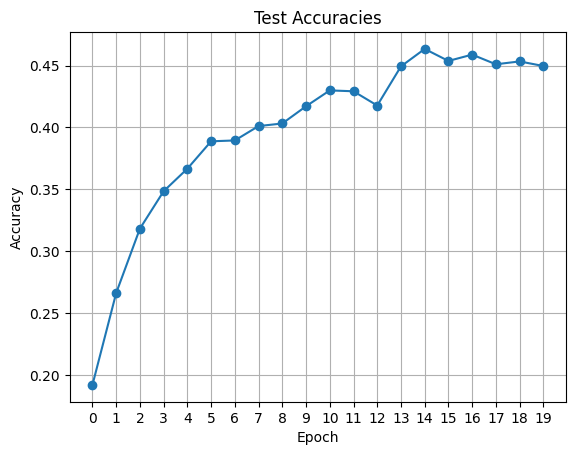

In [22]:
epochs = range(0, len(test_accuracies))

plt.plot(epochs, test_accuracies, marker='o')
plt.title('Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()